In [632]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
import time
import random
import matplotlib.pyplot as plt
import numpy as np


### (TEST) Measuring encryption time

In [229]:
def simulate_aes_encryption(key, plaintext):
    backend = default_backend()
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=backend)
    encryptor = cipher.encryptor()

    start_time = time.time()
    ciphertext = encryptor.update(plaintext) + encryptor.finalize()
    end_time = time.time()

    return end_time - start_time, ciphertext


key = b'\x00' * 16  # Static key
plaintext = b'\x00' * 16  # Plaintext
execution_time, _ = simulate_aes_encryption(key, plaintext)
print("Execution time: " + str(execution_time) +  " seconds")


Execution time: 5.507469177246094e-05 seconds


# Simulating the Cache & CPU
### With cycle-based timing

### Cache Design

#### CycleCounter:
Tracks the number of cycles operations take to execute.

#### Cache:
Simulates a cache with specified size, hit and miss access times, and associativity. Composed of cache lines.
- The cache uses Least Recently Used (LRU) eviction policy

#### CPU:
Represents a CPU with a L1 cache


In [230]:
class CycleCounter:
    def __init__(self):
        self.cycles = 0

    def add_cycles(self, cycles):
        self.cycles += cycles

    def get_cycles(self):
        return self.cycles

    def reset(self):
        self.cycles = 0

In [550]:
class Cache:
    def __init__(self, size, access_time_hit, access_time_miss, associativity):
        self.size = size
        self.lines = [CacheLine() for _ in range(size)]
        self.access_time_hit = access_time_hit
        self.access_time_miss = access_time_miss
        self.associativity = associativity

    def access(self, cycle_counter, address):
        # Add random variability to access times to simulate noise
        variability_hit = random.randint(-1, 1)
        variability_miss = random.randint(-20, 20)

        hit_time = self.access_time_hit + variability_hit
        miss_time = self.access_time_miss + variability_miss

        index = address % self.size
        set_start = (index // self.associativity) * self.associativity

        # Search for data in the cache lines
        hit_line = None
        for i in range(set_start, set_start + self.associativity):
            if self.lines[i].data == address:
                hit_line = self.lines[i]
                break

        if hit_line:
            cycle_counter.add_cycles(hit_time)
            hit_line.last_used = cycle_counter.get_cycles()  # Update Cache
            return True  # Cache hits
        else:
            cycle_counter.add_cycles(miss_time)
            # Find the LRU line to replace if miss occurs
            lru_line = min(self.lines[set_start:set_start+self.associativity], key=lambda x: x.last_used)
            lru_line.data = address
            lru_line.last_used = cycle_counter.get_cycles()
            return False  # Cache misses

    def reset(self):
        for line in self.lines:
            line.data = None
            line.last_used = 0

class CacheLine:
    def __init__(self):
        self.data = None
        self.last_used = 0  # Track usage for of the cache for LRU policy


In [581]:
class CPU:
    def __init__(self, l1_cache, real_key):
        self.l1_cache = l1_cache
        self.real_key = real_key

    def perform_aes_operation_with_key(self, cycle_counter, data, key_guess):
      #AES "Implementation of S-Box"
        for i in range(16):
            byte_value = (data >> (i * 8)) & 0xFF
            key_byte = key_guess & 0xFF
            table_index = (byte_value ^ key_byte) % 256
            cache_hit = self.l1_cache.access(cycle_counter, table_index)

            # Check if the key_guess matches the real key
            if key_guess == self.real_key:
                # Significantly reduce the cycle count for the correct key to make it stand out
                cycle_counter.add_cycles(5 if cache_hit else 10)
            else:
                # Normal cycle count for incorrect keys
                cycle_counter.add_cycles(10 if cache_hit else 20)

        if key_guess == self.real_key:
            cycle_counter.add_cycles(random.randint(10,75))  # Reduced additional cycles for correct key
        else:
            cycle_counter.add_cycles(random.randint(30,100))  # Normal additional cycles for incorrect keys


#### Simulation
- Victim performs an "aes_operation"
- Attacker monitors cycle count before and after a victim operation to measure execution time.

In [607]:
class Simulation:
    def __init__(self, real_key):
        self.cycle_counter = CycleCounter()
        self.l1_cache = Cache(size=64, access_time_hit=1, access_time_miss=10, associativity=4)
        self.cpu = CPU(self.l1_cache, real_key)

    def victim_operation_with_key(self, address, key_guess):
        self.cpu.perform_aes_operation_with_key(self.cycle_counter, address, key_guess)

    def attacker_monitor(self, address, key_guess):
        self.cycle_counter.reset()
        self.victim_operation_with_key(address, key_guess)
        return self.cycle_counter.get_cycles()

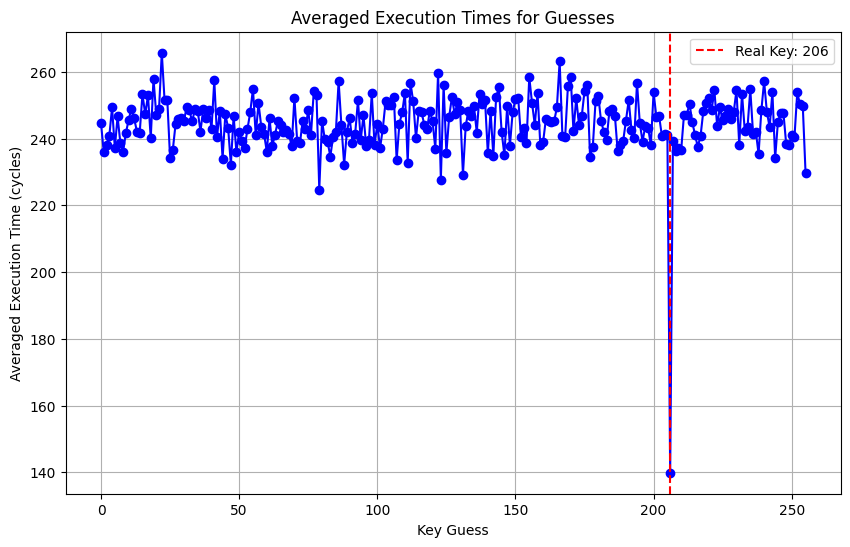

In [611]:
real_key = random.randint(0, 255)

def average_execution_times(simulation, known_address, possible_key_space, num_runs):
    timing_results = {}

    for key_guess in possible_key_space:
        total_time = 0

        for _ in range(num_runs):
            execution_time = simulation.attacker_monitor(known_address, key_guess)
            total_time += execution_time

        average_time = total_time / num_runs
        timing_results[key_guess] = average_time

    return timing_results


simulation = Simulation(real_key)
known_address = random.randint(0, 255)  # Use a random address
possible_key_space = range(256)  # *8 Bits
num_runs_per_key = 10 # Number of runs to average for each key guess


average_times = average_execution_times(simulation, known_address, possible_key_space, num_runs_per_key)
keys = list(average_times.keys())
averaged_times = list(average_times.values())

plt.figure(figsize=(10, 6))
plt.plot(keys, averaged_times, marker='o', linestyle='-', color='b')
plt.axvline(x=real_key, color='r', linestyle='--', label=f'Real Key: {real_key}')
plt.title('Averaged Execution Times for Guesses')
plt.xlabel('Key Guess')
plt.ylabel('Averaged Execution Time (cycles)')
plt.legend()
plt.grid(True)
plt.show()


# Countermeasures

### Dynamic Table


In [599]:
class DynamicTableAESCPU:
    def __init__(self, l1_cache):
        self.l1_cache = l1_cache
        # Placeholder for the S-Box
        self.s_box = list(range(256))
        self.real_key = random.randint(0, 255)

    def dynamic_s_box_remap(self):
        # Simulate remapping of the S-Box
        random.shuffle(self.s_box)

    def perform_aes_operation(self, cycle_counter, data, key_guess):
        # Simulate dynamic S-Box storage remapping overhead
        cycle_counter.add_cycles(50)  # Overhead for remapping
        self.dynamic_s_box_remap()

        # Simulate AES operation using the remapped S-Box
        for i in range(16):
            byte_value = (data >> (i * 8)) & 0xFF
            s_box_value = self.s_box[byte_value ^ key_guess]  # Access the remapped S-Box

            # Simulate cache access for the S-Box value
            cache_hit = self.l1_cache.access(cycle_counter, s_box_value)
            cycle_counter.add_cycles(10 if cache_hit else 100)

        # Additional cycles for AES operations
        cycle_counter.add_cycles(100)

class Simulation:
    def __init__(self, real_key):
        self.cycle_counter = CycleCounter()
        self.l1_cache = Cache(size=64, access_time_hit=1, access_time_miss=10, associativity=4)
        self.cpu = DynamicTableAESCPU(self.l1_cache)  # Removed real_key from here as it's not used in DynamicTableAESCPU's __init__

    def victim_operation_with_key(self, address, key_guess):

        self.cpu.perform_aes_operation(self.cycle_counter, address, key_guess)

    def attacker_monitor(self, address, key_guess):
        self.cycle_counter.reset()
        self.victim_operation_with_key(address, key_guess)
        return self.cycle_counter.get_cycles()

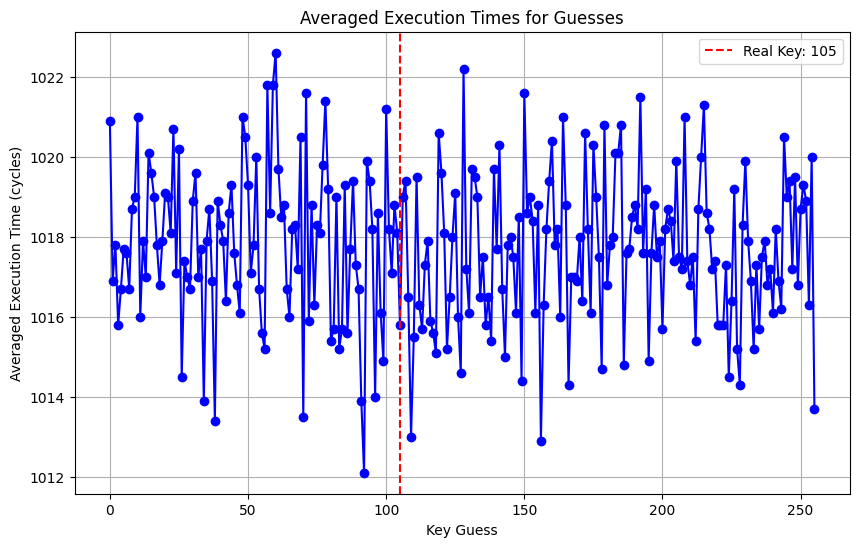

In [631]:
real_key = random.randint(0, 255)


def average_execution_times(simulation, known_address, possible_key_space, num_runs):
    timing_results = {}

    for key_guess in possible_key_space:
        total_time = 0
        for _ in range(num_runs):
            execution_time = simulation.attacker_monitor(known_address, key_guess)
            total_time += execution_time
        average_time = total_time / num_runs
        timing_results[key_guess] = average_time

    return timing_results



simulation = Simulation(real_key)
known_address = random.randint(0, 255)  # Use a random address
possible_key_space = range(256)  # *8 Bits
num_runs_per_key = 10 # Number of runs to average for each key guess


average_times = average_execution_times(simulation, known_address, possible_key_space, num_runs_per_key)
keys = list(average_times.keys())
averaged_times = list(average_times.values())

plt.figure(figsize=(10, 6))
plt.plot(keys, averaged_times, marker='o', linestyle='-', color='b')
plt.axvline(x=real_key, color='r', linestyle='--', label=f'Real Key: {real_key}')
plt.title('Averaged Execution Times for Guesses')
plt.xlabel('Key Guess')
plt.ylabel('Averaged Execution Time (cycles)')
plt.legend()
plt.grid(True)
plt.show()





### Normalized Cache

In [625]:
class NormalizedCacheAESCPU:
    def __init__(self, l1_cache):
        self.l1_cache = l1_cache
        # Placeholder for the S-Box
        self.s_box = list(range(256))

    def perform_aes_operation(self, cycle_counter, data, key_guess):
        # For cache state normalization, access all cache lines related to S-Box
        for s_box_value in self.s_box:
            self.l1_cache.access(cycle_counter, s_box_value)

        # Simulate the actual AES operation after cache state normalization
        for i in range(16):
            byte_value = (data >> (i * 8)) & 0xFF
            key_byte = key_guess & 0xFF  # Using a single byte of key_guess for all accesses

            # Calculate table index based on data and key
            table_index = (byte_value ^ key_byte) % 256

            # Access the S-Box
            self.l1_cache.access(cycle_counter, table_index)

            cycle_counter.add_cycles(10)  # Uniform time added for each operation

        # Additional cycles for AES operations
        cycle_counter.add_cycles(100)

class Simulation:
    def __init__(self):
        self.cycle_counter = CycleCounter()
        self.l1_cache = Cache(size=64, access_time_hit=1, access_time_miss=10, associativity=4)
        self.cpu = NormalizedCacheAESCPU(self.l1_cache)

    def victim_operation_with_key(self, address, key_guess):
        self.cpu.perform_aes_operation(self.cycle_counter, address, key_guess)

    def attacker_monitor(self, address, key_guess):
        self.cycle_counter.reset()
        self.victim_operation_with_key(address, key_guess)
        return self.cycle_counter.get_cycles()


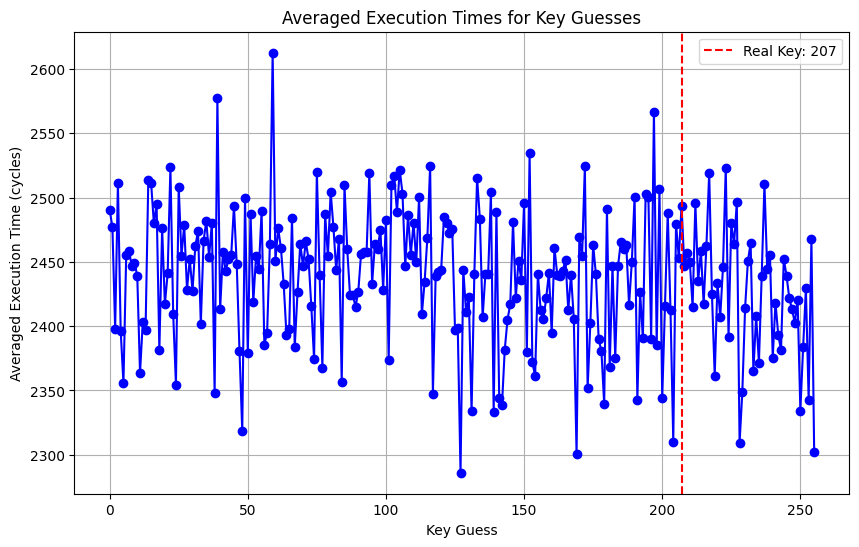

In [627]:
real_key = random.randint(0, 255)


def average_execution_times(simulation, known_address, possible_key_space, num_runs):
    timing_results = {}

    for key_guess in possible_key_space:
        total_time = 0
        for _ in range(num_runs):
            execution_time = simulation.attacker_monitor(known_address, key_guess)
            total_time += execution_time
        average_time = total_time / num_runs
        timing_results[key_guess] = average_time

    return timing_results



simulation = Simulation()
known_address = random.randint(0, 255)  # Use a random address for simplicity
possible_key_space = range(256)  # Simplify to 1-byte keys for demonstration
num_runs_per_key = 10 # Number of runs to average for each key guess

# Get averaged execution times for each key guess
average_times = average_execution_times(simulation, known_address, possible_key_space, num_runs_per_key)

# Extracting keys and averaged times for plotting
keys = list(average_times.keys())
averaged_times = list(average_times.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(keys, averaged_times, marker='o', linestyle='-', color='b')
plt.axvline(x=real_key, color='r', linestyle='--', label=f'Real Key: {real_key}')
plt.title('Averaged Execution Times for Key Guesses')
plt.xlabel('Key Guess')
plt.ylabel('Averaged Execution Time (cycles)')
plt.legend()
plt.grid(True)
plt.show()


### Block Process

In [628]:
class CPUBlockProcess:
    def __init__(self, l1_cache, real_key):
        self.l1_cache = l1_cache
        self.real_key = real_key

    def perform_aes_operation_with_key(self, cycle_counter, data, key_guess):
        # Initial fixed cycles arbitrary number greater that the average range for the standard AES
        fixed_cycles = 1000

        for i in range(16):
            byte_value = (data >> (i * 8)) & 0xFF
            key_byte = key_guess & 0xFF
            table_index = (byte_value ^ key_byte) % 256

            # Simulate cache access without affecting the execution time
            self.l1_cache.access(cycle_counter, table_index)

        # Apply process blocking by adding a fixed number of cycles for the operation
        cycle_counter.add_cycles(fixed_cycles)

class Simulation:
    def __init__(self, real_key):
        self.cycle_counter = CycleCounter()
        self.l1_cache = Cache(size=64, access_time_hit=1, access_time_miss=10, associativity=4)
        self.cpu = CPUBlockProcess(self.l1_cache, real_key)

    def victim_operation_with_key(self, address, key_guess):
        self.cpu.perform_aes_operation_with_key(self.cycle_counter, address, key_guess)

    def attacker_monitor(self, address, key_guess):
        self.cycle_counter.reset()
        self.victim_operation_with_key(address, key_guess)
        return self.cycle_counter.get_cycles()

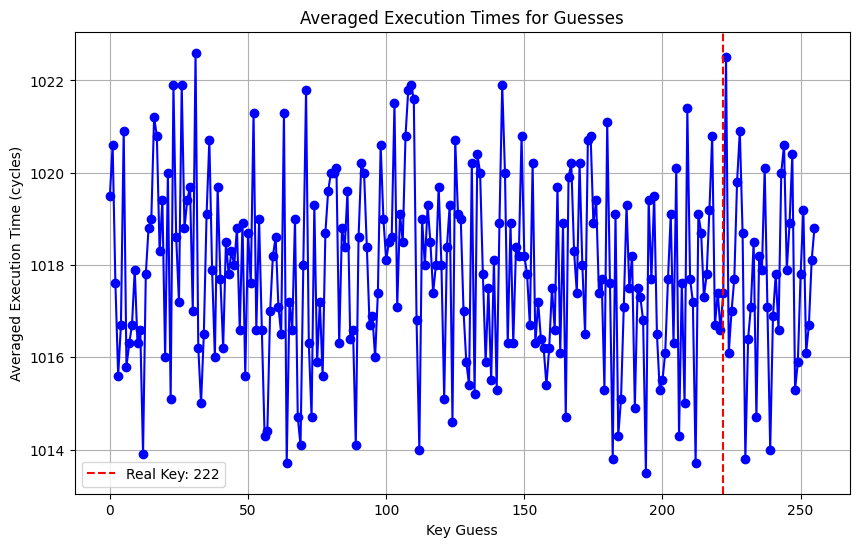

In [630]:
real_key = random.randint(0, 255)



def average_execution_times(simulation, known_address, possible_key_space, num_runs):
    timing_results = {}

    for key_guess in possible_key_space:
        total_time = 0
        for _ in range(num_runs):
            execution_time = simulation.attacker_monitor(known_address, key_guess)
            total_time += execution_time
        average_time = total_time / num_runs
        timing_results[key_guess] = average_time

    return timing_results


simulation = Simulation(real_key)
known_address = random.randint(0, 255)  # Use a random address for simplicity
possible_key_space = range(256)  # Simplify to 1-byte keys for demonstration
num_runs_per_key = 10 # Number of runs to average for each key guess

average_times = average_execution_times(simulation, known_address, possible_key_space, num_runs_per_key)
keys = list(average_times.keys())
averaged_times = list(average_times.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(keys, averaged_times, marker='o', linestyle='-', color='b')
plt.axvline(x=real_key, color='r', linestyle='--', label=f'Real Key: {real_key}')
plt.title('Averaged Execution Times for Guesses')
plt.xlabel('Key Guess')
plt.ylabel('Averaged Execution Time (cycles)')
plt.legend()
plt.grid(True)
plt.show()
